In [1]:
# Django, Geopandas, etc related setup.

import os, sys
PROJECTPATH = os.environ['PWD']
sys.path.insert(0, PROJECTPATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mygeo.settings")
os.environ.setdefault("DJANGO_PROJECT", "mygeo")
os.environ.setdefault("LOCAL_DB", "1")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.chdir(PROJECTPATH)
import django
django.setup()

import json
import pprint
import geopandas
import shapely
from django.core.serializers import serialize
from shapely.geometry import GeometryCollection
from shapely.ops import triangulate

from world.models import Parcel, ZoningBase, BuildingOutlines

print("INITIALIZATION DONE")



**** RUNNING IN (insecure) DEVELOPMENT MODE ****
****** LOCAL DATABASE ******


INITIALIZATION DONE


[ 481344.90159829 3627355.3194314   481388.55213911 3627386.76797389]
(0.0, 0.0, 43.65054081886774, 31.448542487807572)


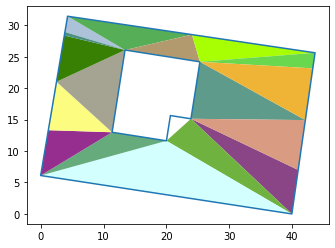

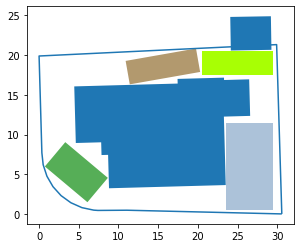

In [2]:
# ALGORITHM: Find biggest rectangles that fit on a parcel.
from notebooks.notebook_util import nb_exit, display_polys_on_lot
from lib.parcel_lib import biggestPolyOverRotations
from shapely.geometry import MultiPolygon

# apn = '4302030800'  # working, original concave parcel
apn = '3090652100'  # interesting convex parcel
# apn = '4255451500'  # parcel with lots of room, identified by Richard I think?

# Get parcel and building info for this zone.
parcel = Parcel.objects.get(apn=apn)
buildings = BuildingOutlines.objects.filter(geom__intersects=parcel.geom)

# convert building and parcel data into a UTM projection, which is a flat
# geometry where each unit is 1 meter.
serialized_parcel = serialize('geojson', [parcel], geometry_field='geom', )
serialized_buildings = serialize('geojson', buildings, geometry_field='geom', fields=('apn', 'geom',))
parcel_data_frame = geopandas.GeoDataFrame.from_features(json.loads(serialized_parcel), crs="EPSG:4326")
buildings_data_frame = geopandas.GeoDataFrame.from_features(json.loads(serialized_buildings), crs="EPSG:4326")
parcel_in_utm = parcel_data_frame.to_crs(parcel_data_frame.estimate_utm_crs())
buildings_in_utm = buildings_data_frame.to_crs(buildings_data_frame.estimate_utm_crs())
# lot_square_meters = parcel_in_utm.area
# print ("Lot: ", lot_square_meters)
# print ("buildings: ", buildings_in_utm.area)

# do some basic sanity checks

assert (len(parcel_in_utm.boundary[0].geoms) == 1)
assert (len(buildings_in_utm.boundary) == 2)
assert (len(buildings_in_utm.boundary[0].geoms) == 1)

# TODO: Algorithm currently only uses first building. extend it to multiple buildings
# building_lines = MultiLineString(buildings_in_utm.geometry)
assert (len(parcel_in_utm.boundary) == 1)

offset_bounds = parcel_in_utm.total_bounds
print (offset_bounds)

# move parcel coordinates to be 0,0 based so they're easier to see.
parcel_boundary_multipoly = parcel_in_utm.translate(xoff=-offset_bounds[0], yoff=-offset_bounds[1])[0]
zero_bounds = parcel_boundary_multipoly.bounds

print (zero_bounds)

building_line_string = buildings_in_utm.boundary[1].geoms[0]
# move building coordinates to be 0,0 based so they're easier to see.
building_line_string = shapely.affinity.translate(building_line_string, xoff=-offset_bounds[0], yoff=-offset_bounds[1])
triags = triangulate(GeometryCollection([building_line_string, parcel_boundary_multipoly]))

# Find triangles not in the building:
# DE-9IM gives a 3x3 matrix of how two objects relate. It's quite fascinating.
# Check out the diagram in https://postgis.net/workshops/postgis-intro/de9im.html
de9im = [x.relate(building_line_string.convex_hull) for idx,x in enumerate (triags)]
kept_triangles = [x for idx,x in enumerate(triags) if de9im[idx][0]=='F' ]
kept_triangles_gs = geopandas.GeoSeries(kept_triangles)

lot_df = geopandas.GeoDataFrame(geometry=[building_line_string, parcel_boundary_multipoly.boundary], crs="EPSG:4326")

display_polys_on_lot(lot_df, kept_triangles)

avail_geom = MultiPolygon(kept_triangles)
placed_polys = []

display_polys_on_lot(lot_df, avail_geom)
# Now find the largest rectangles we can fit on the available geometries
placed_polys = find_largest_rectangles_on_avail_geom(avail_geom, num_rects=4, max_aspect_ratio=2.5)

display_polys_on_lot(lot_df, placed_polys)
# nb_exit()


In [3]:
## NOT WORKING: Find rectangles: Implementation attempt from old Dr Dobbs journal.
# Ref: https://stackoverflow.com/questions/7245/puzzle-find-largest-rectangle-maximal-rectangle-problem
# and https://www.drdobbs.com/database/the-maximal-rectangle-problem/184410529

def not_working():
    from rasterio import features
    raster_dims = [30,33]
    b = features.rasterize(kept_triangles, raster_dims)
    cache = [0] * (raster_dims[0]+1)
    stack = []
    best_rect = ((0,0),(-1,-1))
    best_area = 0
    def update_cache(x):
        for y in range (0, 30):
            if (b[y][x]==1): # inside polygon
                cache[y] = cache[y]+1
                #print (f'Cache @ y={y} : {cache[y]}')
            elif (b[y][x]==0):
                cache[y] = 0
            else:
                print ("Unkknown b value: ", b[y][x])

    for x in range(32,-1,-1):
        update_cache(x)
        open_width=0  # width of widest open rect
        for y in range(31):
            # print ("X,Y is ", x, y)
            if (cache[y] > open_width): # opening new rectangle(s)
                stack.append((y, open_width))
                print (f'{x},{y} OPEN. Push (y, open_width) =({y}, {open_width})')
                open_width = cache[y]
            elif (cache[y] < open_width):
                while (cache[y] < open_width): # closing rectnagles
                    (y0, w0)= stack.pop()
                    print (f'{x},{y} CLOSING popped y0,w0 = ({y0}, {w0})')
                    area = open_width*(y-y0)
                    if (area > best_area):
                        best_area = area
                        best_rect = ((x, y0), ((x-open_width+1), y-1))
                        print ("  BETTER Rect:", best_rect, " . Area=", best_area)
                    open_width = w0
                open_width = cache[y]
                if (open_width != 0): # popped an active opening
                    stack.append ((y0, open_width))

    print (best_rect)
    print (cache)


In [ ]:
# MIRA MESA NEIGHBORHOOD:
(-117.17987773162996, 32.930825570911985), (-117.12513392170659, 32.894946222075184)